In [ ]:
# !pip install xarray eotransform_pandas dask geopathfinder rioxarray matplotlib

In [64]:
import numpy as np
import glob
import os
from datetime import datetime
from pprint import pprint
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

In [9]:
DATA_PATH = './data/S1_CSAR_IWGRDH_fields/S1_CSAR_IWGRDH/SIG0/V0M2R4/EQUI7_AF020M/E069N087T3'

In [11]:
##### yeoda_naming_convention
# fields_def = OrderedDict([
#     ('var_name', {'len': 0}),
#     ('datetime_1', {'len': 0}),
#     ('datetime_2', {'len': 0}),
#     ('band', {'len': 0}),
#     ('extra_field', {'len': 0}),
#     ('tile_name', {'len': 0}),
#     ('grid_name', {'len': 0}),
#     ('data_version', {'len': 0}),
#     ('sensor_field', {'len': 0}),
#     ('creator', {'len': 0})
# ])

In [81]:
file_list = list(glob.glob(f"{DATA_PATH}/*.tif"))
mylist = [f.split('/')[-1] for f in file_list]
pprint(mylist[:5])

['SIG0_20211206T032643__VV_D123_E069N087T3_AF020M_V0M2R4_S1BIWGRDH_TUWIEN.tif',
 'SIG0_20211222T153302__VV_A014_E069N087T3_AF020M_V0M2R4_S1BIWGRDH_TUWIEN.tif',
 'SIG0_20220311T033536__VV_D021_E069N087T3_AF020M_V1M1R1_S1AIWGRDH_TUWIEN.tif',
 'SIG0_20220126T154115__VV_A087_E069N087T3_AF020M_V1M1R1_S1AIWGRDH_TUWIEN.tif',
 'SIG0_20220214T153303__VV_A014_E069N087T3_AF020M_V1M1R1_S1AIWGRDH_TUWIEN.tif']


In [49]:
date_str_list = [item.split('_')[1] for item in mylist]
date_indices = [datetime.strptime(d, '%Y%m%dT%H%M%S') for d in date_str_list]
pprint(date_indices[:5])

[datetime.datetime(2021, 12, 6, 3, 26, 43),
 datetime.datetime(2021, 12, 22, 15, 33, 2),
 datetime.datetime(2022, 3, 11, 3, 35, 36),
 datetime.datetime(2022, 1, 26, 15, 41, 15),
 datetime.datetime(2022, 2, 14, 15, 33, 3)]


In [13]:
import xarray as xr
from pathlib import Path
from eotransform_pandas.filesystem.gather import gather_files

from eotransform_pandas.filesystem.naming.geopathfinder_conventions import yeoda_naming_convention

# gather all the tiffs in a pandas DataFrame (the file names follow a
# special yeoda naming convention which is parsed and populates the df
# with meta data such as sensing time

tiffs_df = gather_files(Path(DATA_PATH), yeoda_naming_convention, index="datetime_1")
# index="datetime_1" means
# tiffs are sorted by sensing time which is what you generally want when
# looking at time series data

# you can do some other filtering sorting or processing of the data
# frame here of course to only select the files you are interested in
# using standard pandas procedures

# then load the stack of tiffs into a data cube

# the 'chunk={}' means that files are lazy loaded and xarray will use
# dask for processing which can speed up things on machines with multiple
# cores

# 'concat_dim' signifies what the stacking order of the tiffs means - as
# mentioned before you usually want to stack by sensing time, hence 'time'

stack_ds = xr.open_mfdataset(tiffs_df['filepath'], engine='rasterio',
chunks={}, combine='nested', concat_dim='time')

# 'xr.open_mfdataset' returns a Dataset object containing one DataArray
# called 'band_data' this is just how GeoTiffs do

stack_da = stack_ds['band_data']

# now you can select your region of interest - I'd recommend keeping it
# small for now so you don't have to process for ages

# look into the xarray docs for how to select an manipulate the data
# cube https://docs.xarray.dev/en/stable/user-guide/indexing.html

# this function transforms the data in decibel (which is how the data is
# stored within the GeoTiffs) to linear space

# def db2lin(x):
#     return 10.0 ** (x / 10.0)

# and the other way around from linear scale to logarithmic

# def lin2db(x):
#     return 10 * np.log10(x)

In [14]:
stack_ds

<xarray.Dataset>
Dimensions:      (band: 1, x: 15000, y: 15000, time: 189)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.9e+06 6.9e+06 6.9e+06 ... 7.2e+06 7.2e+06 7.2e+06
  * y            (y) float64 9e+06 9e+06 9e+06 9e+06 ... 8.7e+06 8.7e+06 8.7e+06
    spatial_ref  int64 0
Dimensions without coordinates: time
Data variables:
    band_data    (time, band, y, x) float32 dask.array<chunksize=(1, 1, 15000, 15000), meta=np.ndarray>

In [16]:
stack_da

<xarray.DataArray 'band_data' (time: 189, band: 1, y: 15000, x: 15000)>
dask.array<concatenate, shape=(189, 1, 15000, 15000), dtype=float32, chunksize=(1, 1, 15000, 15000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.9e+06 6.9e+06 6.9e+06 ... 7.2e+06 7.2e+06 7.2e+06
  * y            (y) float64 9e+06 9e+06 9e+06 9e+06 ... 8.7e+06 8.7e+06 8.7e+06
    spatial_ref  int64 0
Dimensions without coordinates: time
Attributes: (12/29)
    abs_orbit_number:       29863
    AREA_OR_POINT:          Area
    border_noise_removed:   True
    creation_date:          2021-12-04 00:18:31
    creator:                gfm_ops
    dem_source:             /eodc/private/jrc_gfm/gfm_scratch/copdem/CopDEM30...
    ...                     ...
    worker_git_commit:      none
    worker_git_tag:         from v0.2.3 to v0.2.4
    worker_name:            s1_sigma
    wrapper_git_commit:     none
    wrapper_git_tag:        v0.1.4
    wrapper_name:           sentinel_1_reprocessing

In [17]:
stack_ds.keys()

KeysView(<xarray.Dataset>
Dimensions:      (band: 1, x: 15000, y: 15000, time: 189)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.9e+06 6.9e+06 6.9e+06 ... 7.2e+06 7.2e+06 7.2e+06
  * y            (y) float64 9e+06 9e+06 9e+06 9e+06 ... 8.7e+06 8.7e+06 8.7e+06
    spatial_ref  int64 0
Dimensions without coordinates: time
Data variables:
    band_data    (time, band, y, x) float32 dask.array<chunksize=(1, 1, 15000, 15000), meta=np.ndarray>)

In [18]:
stack_da.shape

(189, 1, 15000, 15000)

In [19]:
%%time
# v = stack_da[0:100,:,8,8].values
v = stack_da[:,:,8,8].values

CPU times: user 3min 30s, sys: 1min 48s, total: 5min 18s
Wall time: 5min 18s


In [59]:
flatted_v = [i[0] for i in v]
df = pd.DataFrame(zip(date_indices, flatted_v), columns=['timestamp', 'value'])

In [60]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,timestamp,value
0,2021-12-06 03:26:43,NaN
1,2021-12-22 15:33:02,NaN
2,2022-03-11 03:35:36,-25.600000
3,2022-01-26 15:41:15,-18.400000
4,2022-02-14 15:33:03,NaN
5,2022-01-05 03:27:28,NaN
6,2022-01-21 15:32:39,NaN
7,2022-01-29 03:27:27,NaN
8,2022-01-22 03:35:37,NaN
9,2022-01-03 03:43:16,NaN


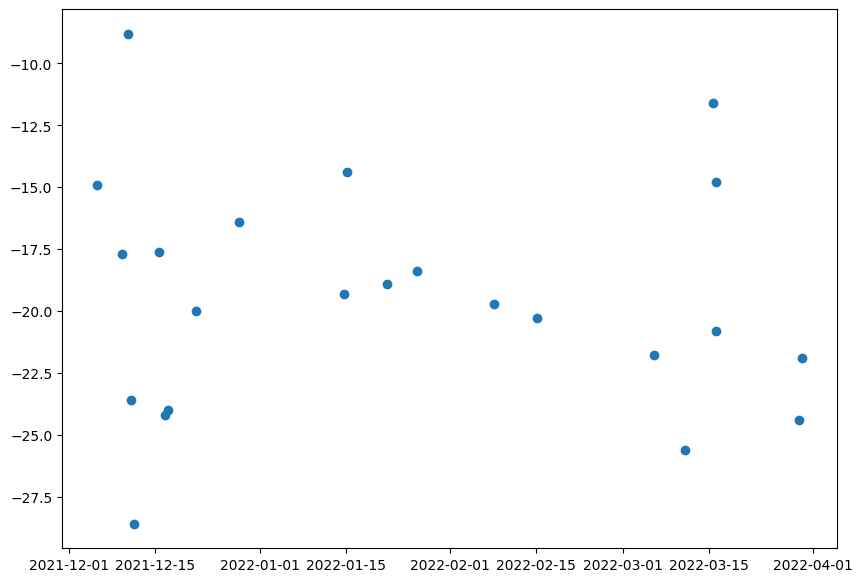

In [79]:
# plot_df = df[~np.isnan(df.value)]

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)
ax.scatter(df.timestamp, df.value)

### Sigma Nought
Scattering coefficient, or the conventional measure of the strength of radar signals reflected by a distributed scatterer, usually expressed in dB. It is a normalised dimensionless number, comparing the strength observed to that expected from an area of one square meter. Sigma nought is defined with respect to the nominally horizontal plane, and in general has a significant variation with incidence angle, wavelength, and polarisation, as well as with properties of the scattering surface itself.